# Case Study #2: Comparative Analysis of CNN and Patch-based LSTM Architectures for Image Classification 

## 1. Setup

### 1.1 Libraries used:

In [30]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time

from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

from torchvision.models import alexnet

### 1.2 Setting hyperparameters

In [12]:
batch_size = 64          # Number of samples per batch
num_epochs = 10          # Total number of training epochs
learning_rate = 0.001    # Learning rate for optimizer
patch_size = 4           # Used only for Patch-based LSTM
hidden_size = 128        # Hidden layer size for LSTM
num_classes = 10         # Number of output classes for BOTH DATASETS

### 1.3 Defining GPU/CPU device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

Training on: cuda


## 2. Dataset Preprocessing and Preparation

### 2.1 Datasets Loading & Preparing the data for training with DataLoaders

In [13]:
def load_dataset(dataset_name, batch_size=64, use_rgb=False, resize_to_224=False):
    transform_list = []

    if resize_to_224:
        transform_list.append(transforms.Resize((224, 224)))

    if use_rgb:
        transform_list.append(transforms.Grayscale(num_output_channels=3))  # For AlexNet + MNIST

    transform_list.append(transforms.ToTensor())

    if dataset_name == "MNIST":
        transform = transforms.Compose(transform_list)

        train_data = datasets.MNIST(
            root='data',
            train=True,
            download=True,
            transform=transform
        )

        test_data = datasets.MNIST(
            root='data',
            train=False,
            download=True,
            transform=transform
        )

        in_channels = 3 if use_rgb else 1
        image_size = 224 if resize_to_224 else 28
        class_names = [str(i) for i in range(10)]

    elif dataset_name == "CIFAR10":
        transform_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
        transform = transforms.Compose(transform_list)

        train_data = datasets.CIFAR10(
            root='data',
            train=True,
            download=True,
            transform=transform
        )

        test_data = datasets.CIFAR10(
            root='data',
            train=False,
            download=True,
            transform=transform
        )

        in_channels = 3
        image_size = 224 if resize_to_224 else 32
        class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    else:
        raise ValueError("Unsupported dataset")

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_data, test_data, train_loader, test_loader, in_channels, image_size, class_names

### 2.2 Iterating and Visualizing for each Dataset

#### MNIST Dataset:

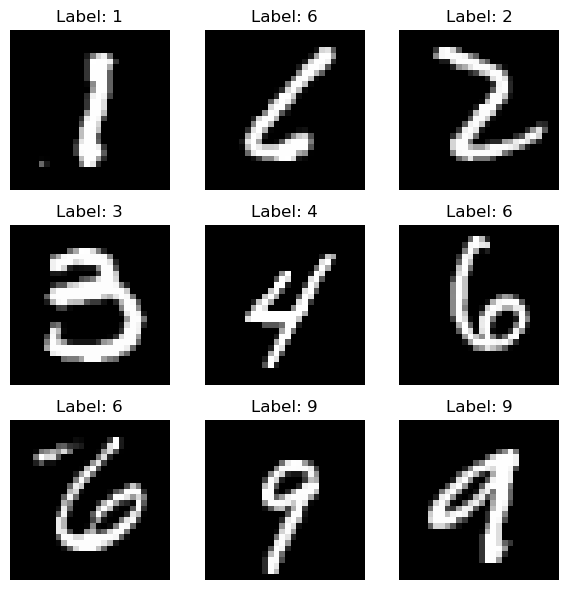

In [5]:
train_data, test_data, train_loader, test_loader, in_channels, img_size, class_names = load_dataset("MNIST")

def show_mnist_samples(dataset):
    plt.figure(figsize=(6, 6))
    for i in range(9):
        idx = torch.randint(len(dataset), size=(1,)).item()
        image, label = dataset[idx]
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.squeeze(), cmap="gray")
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    
show_mnist_samples(train_data)

#### CIFAR-10 Dataset: 

Files already downloaded and verified
Files already downloaded and verified


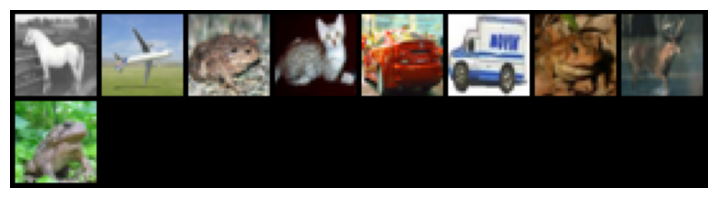

Labels:
horse plane frog cat car truck frog deer frog


In [6]:
train_data, test_data, train_loader, test_loader, in_channels, img_size, class_names = load_dataset("CIFAR10")

def show_cifar10_samples(dataset, class_names):
    loader = DataLoader(dataset, batch_size=9, shuffle=True)
    images, labels = next(iter(loader))

    images = images / 2 + 0.5     # Unnormalize from [-1, 1] → [0, 1]
    npimg = torchvision.utils.make_grid(images).numpy()

    plt.figure(figsize=(9, 3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

    print("Labels:")
    print(' '.join(class_names[label] for label in labels))

show_cifar10_samples(train_data, class_names)

### 2.3 Patch Preparation for LSTM

- For LSTM: divide each image into non-overlapping patches (e.g., 4×4 or 8×8). Flatten each patch to form a sequence of vectors.

- Taken 4x4 patches: Image size for mnist: 28×28, the result will be:

        28 ÷ 4 = 7 patches along width

        7 × 7 = 49 total patches

        Each patch is of shape (4×4 = 16) → vector of length 16

- Taken 4x4 patches: Image size for cifar-10: 32x32, the result will be:

        32 ÷ 4 = 8 patches along width

        8 × 8 = 64 total patches

        Each patch is of shape (3x4×4 = 48) → vector of length 48

In [6]:
def image_to_patches(images, patch_size=4):
    B, C, H, W = images.shape
    assert H % patch_size == 0 and W % patch_size == 0, "Image size must be divisible by patch size"

    # Step 1: Extract non-overlapping patches
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    # shape: (B, C, H//p, W//p, p, p)

    # Step 2: Rearrange and flatten each patch
    patches = patches.contiguous().view(B, C, -1, patch_size * patch_size)
    patches = patches.permute(0, 2, 1, 3).contiguous().view(B, -1, C * patch_size * patch_size)
    # shape: (B, num_patches, patch_dim)

    return patches

## 3. Model Architectures

### 3.1 Architecture A – CNN Baseline

In [14]:
class CNNBaseline(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNNBaseline, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7 if in_channels == 1 else 64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### 3.2 Architecture B – AlexNet

In [8]:
def get_alexnet_model(num_classes=10, freeze_features=True):
    model = alexnet(pretrained=True)
    
    if freeze_features:
        for param in model.features.parameters():
            param.requires_grad = False

    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    return model

### 3.3 Architecture C – Patch-based LSTM

In [9]:
class PatchLSTM(nn.Module):
    def __init__(self, image_size=28, patch_size=4, in_channels=1, hidden_size=128, num_classes=10):
        super(PatchLSTM, self).__init__()
        self.patch_size = patch_size
        self.hidden_size = hidden_size
        self.num_patches_per_dim = image_size // patch_size
        self.input_dim = in_channels * patch_size * patch_size
        self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        patches = image_to_patches(x, patch_size=self.patch_size)
        out, _ = self.lstm(patches)
        final_out = out[:, -1, :]
        logits = self.fc(final_out)
        return logits

## 4. Training & Evaluation

In [24]:
results = {
    'CNN': {},
    'AlexNet': {},
    'Patch-LSTM': {}
}

### 4.1 Training for CNN


=== Running CNN for MNIST ===


[CNN-MNIST] Epoch 1: 100%|██████████| 938/938 [00:08<00:00, 104.43it/s]


[CNN] Epoch 1/10 | Loss: 0.1794 | Accuracy: 98.39%


[CNN-MNIST] Epoch 2: 100%|██████████| 938/938 [00:08<00:00, 104.96it/s]


[CNN] Epoch 2/10 | Loss: 0.0496 | Accuracy: 98.77%


[CNN-MNIST] Epoch 3: 100%|██████████| 938/938 [00:09<00:00, 101.14it/s]


[CNN] Epoch 3/10 | Loss: 0.0357 | Accuracy: 98.90%


[CNN-MNIST] Epoch 4: 100%|██████████| 938/938 [00:10<00:00, 92.83it/s] 


[CNN] Epoch 4/10 | Loss: 0.0267 | Accuracy: 98.93%


[CNN-MNIST] Epoch 5: 100%|██████████| 938/938 [00:09<00:00, 95.46it/s] 


[CNN] Epoch 5/10 | Loss: 0.0198 | Accuracy: 98.96%


[CNN-MNIST] Epoch 6: 100%|██████████| 938/938 [00:09<00:00, 101.77it/s]


[CNN] Epoch 6/10 | Loss: 0.0157 | Accuracy: 99.15%


[CNN-MNIST] Epoch 7: 100%|██████████| 938/938 [00:09<00:00, 98.39it/s] 


[CNN] Epoch 7/10 | Loss: 0.0118 | Accuracy: 98.92%


[CNN-MNIST] Epoch 8: 100%|██████████| 938/938 [00:09<00:00, 99.16it/s] 


[CNN] Epoch 8/10 | Loss: 0.0108 | Accuracy: 99.12%


[CNN-MNIST] Epoch 9: 100%|██████████| 938/938 [00:09<00:00, 98.67it/s] 


[CNN] Epoch 9/10 | Loss: 0.0082 | Accuracy: 98.91%


[CNN-MNIST] Epoch 10: 100%|██████████| 938/938 [00:09<00:00, 97.05it/s] 


[CNN] Epoch 10/10 | Loss: 0.0077 | Accuracy: 99.07%

 Total Training Time: 94.58 seconds
 Total Inference Time: 39.74 seconds


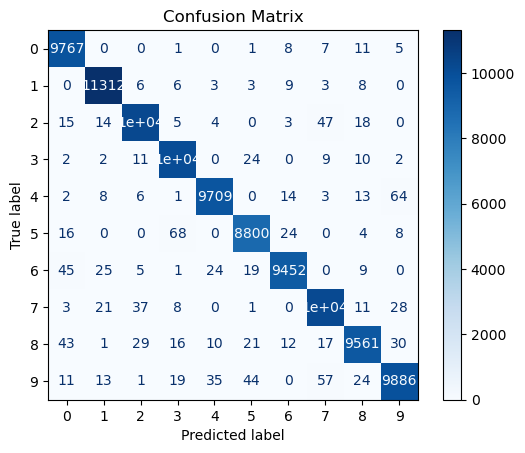

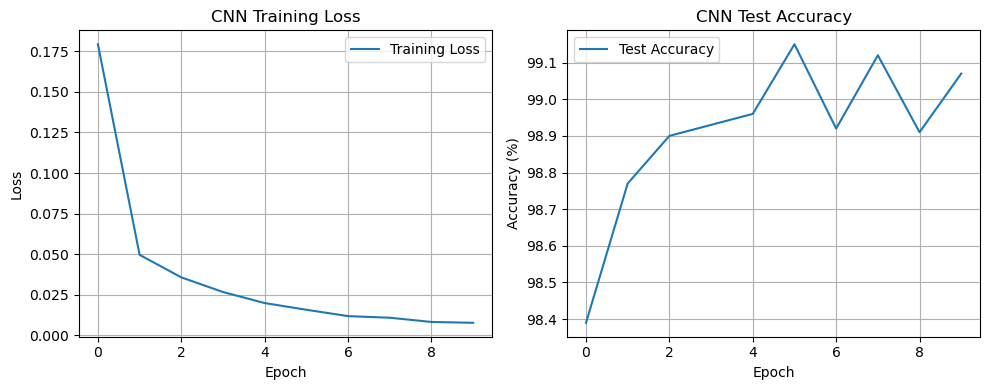


=== Running CNN for CIFAR10 ===
Files already downloaded and verified
Files already downloaded and verified


[CNN-CIFAR10] Epoch 1: 100%|██████████| 782/782 [00:19<00:00, 39.64it/s]


[CNN] Epoch 1/10 | Loss: 1.3481 | Accuracy: 59.00%


[CNN-CIFAR10] Epoch 2: 100%|██████████| 782/782 [00:20<00:00, 38.47it/s]


[CNN] Epoch 2/10 | Loss: 0.9695 | Accuracy: 67.79%


[CNN-CIFAR10] Epoch 3: 100%|██████████| 782/782 [00:19<00:00, 39.39it/s]


[CNN] Epoch 3/10 | Loss: 0.8205 | Accuracy: 69.80%


[CNN-CIFAR10] Epoch 4: 100%|██████████| 782/782 [00:20<00:00, 37.73it/s]


[CNN] Epoch 4/10 | Loss: 0.7095 | Accuracy: 71.82%


[CNN-CIFAR10] Epoch 5: 100%|██████████| 782/782 [00:20<00:00, 38.42it/s]


[CNN] Epoch 5/10 | Loss: 0.6225 | Accuracy: 71.53%


[CNN-CIFAR10] Epoch 6: 100%|██████████| 782/782 [00:20<00:00, 38.13it/s]


[CNN] Epoch 6/10 | Loss: 0.5367 | Accuracy: 71.36%


[CNN-CIFAR10] Epoch 7: 100%|██████████| 782/782 [00:20<00:00, 38.33it/s]


[CNN] Epoch 7/10 | Loss: 0.4571 | Accuracy: 71.69%


[CNN-CIFAR10] Epoch 8: 100%|██████████| 782/782 [00:20<00:00, 37.58it/s]


[CNN] Epoch 8/10 | Loss: 0.3872 | Accuracy: 71.14%


[CNN-CIFAR10] Epoch 9: 100%|██████████| 782/782 [00:20<00:00, 38.92it/s]


[CNN] Epoch 9/10 | Loss: 0.3225 | Accuracy: 72.03%


[CNN-CIFAR10] Epoch 10: 100%|██████████| 782/782 [00:19<00:00, 39.41it/s]


[CNN] Epoch 10/10 | Loss: 0.2579 | Accuracy: 70.89%

 Total Training Time: 202.71 seconds
 Total Inference Time: 85.11 seconds


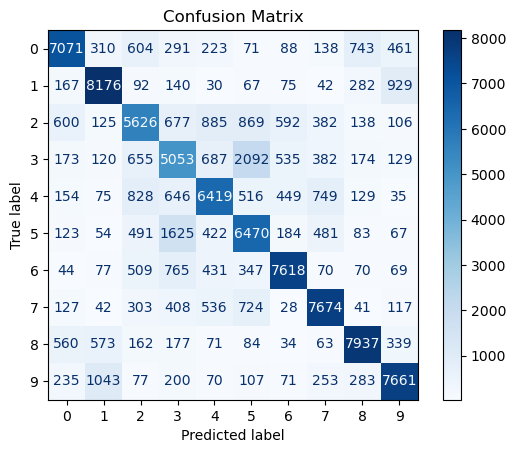

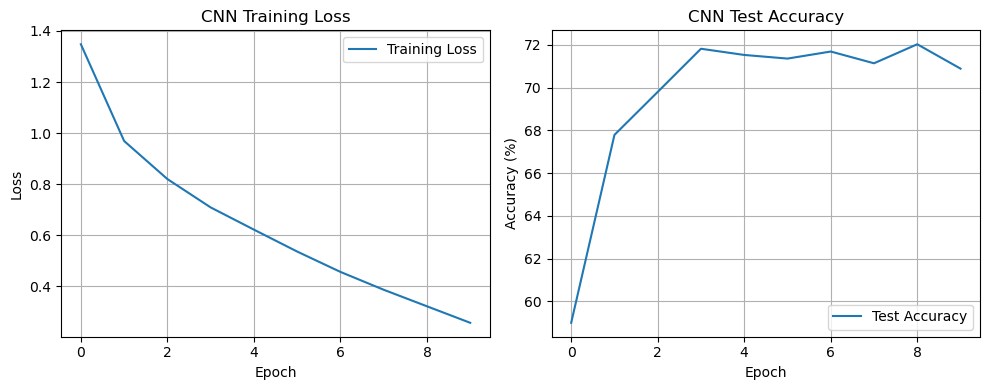

In [25]:
def train_cnn_model(model, train_loader, test_loader, device, dataset_name):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, test_accuracies = [], []
    total_train_time = 0.0
    total_inference_time = 0.0
    all_preds, all_labels = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_start = time.time()

        for images, labels in tqdm(train_loader, desc=f"[CNN-{dataset_name}] Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        total_train_time += time.time() - epoch_start
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        correct, total = 0, 0
        inference_start = time.time()
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
        total_inference_time += time.time() - inference_start

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        print(f"[CNN] Epoch {epoch+1}/{num_epochs} | Loss: {train_losses[-1]:.4f} | Accuracy: {accuracy:.2f}%")

    print(f"\n Total Training Time: {total_train_time:.2f} seconds")
    print(f" Total Inference Time: {total_inference_time:.2f} seconds")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Visualization
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("CNN Training Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("CNN Test Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    results['CNN'][dataset_name] = {
        'Accuracy (%)': test_accuracies[-1],
        'Train Time (s)': total_train_time,
        'Inference Time (s)': total_inference_time
    }


def run_cnn_for_dataset(dataset_name): 
    print(f"\n=== Running CNN for {dataset_name} ===")
    
    train_data, test_data, train_loader, test_loader, in_channels, _, class_names = load_dataset(
        dataset_name,
        batch_size=batch_size,
        use_rgb=False,      
        resize_to_224=False     
    )

    cnn_model = CNNBaseline(in_channels=in_channels, num_classes=len(class_names))
    train_cnn_model(cnn_model, train_loader, test_loader, device, dataset_name)

run_cnn_for_dataset("MNIST")
run_cnn_for_dataset("CIFAR10")

### 4.2 Training for AlexNet


=== Running AlexNet for MNIST ===


[AlexNet-MNIST] Epoch 1: 100%|██████████| 938/938 [01:43<00:00,  9.08it/s]


[AlexNet] Epoch 1/10 | Loss: 0.1594 | Accuracy: 98.32%


[AlexNet-MNIST] Epoch 2: 100%|██████████| 938/938 [01:42<00:00,  9.17it/s]


[AlexNet] Epoch 2/10 | Loss: 0.1063 | Accuracy: 98.52%


[AlexNet-MNIST] Epoch 3: 100%|██████████| 938/938 [01:48<00:00,  8.64it/s]


[AlexNet] Epoch 3/10 | Loss: 0.0931 | Accuracy: 98.81%


[AlexNet-MNIST] Epoch 4: 100%|██████████| 938/938 [01:42<00:00,  9.19it/s]


[AlexNet] Epoch 4/10 | Loss: 0.0784 | Accuracy: 99.06%


[AlexNet-MNIST] Epoch 5: 100%|██████████| 938/938 [01:42<00:00,  9.18it/s]


[AlexNet] Epoch 5/10 | Loss: 0.0768 | Accuracy: 98.91%


[AlexNet-MNIST] Epoch 6: 100%|██████████| 938/938 [01:44<00:00,  8.99it/s]


[AlexNet] Epoch 6/10 | Loss: 0.0689 | Accuracy: 99.04%


[AlexNet-MNIST] Epoch 7: 100%|██████████| 938/938 [01:42<00:00,  9.17it/s]


[AlexNet] Epoch 7/10 | Loss: 0.0652 | Accuracy: 99.15%


[AlexNet-MNIST] Epoch 8: 100%|██████████| 938/938 [01:42<00:00,  9.19it/s]


[AlexNet] Epoch 8/10 | Loss: 0.0613 | Accuracy: 99.13%


[AlexNet-MNIST] Epoch 9: 100%|██████████| 938/938 [01:42<00:00,  9.17it/s]


[AlexNet] Epoch 9/10 | Loss: 0.0569 | Accuracy: 99.11%


[AlexNet-MNIST] Epoch 10: 100%|██████████| 938/938 [01:42<00:00,  9.17it/s]


[AlexNet] Epoch 10/10 | Loss: 0.0530 | Accuracy: 99.11%

 Total Training Time: 1031.89 seconds
 Total Inference Time: 139.29 seconds


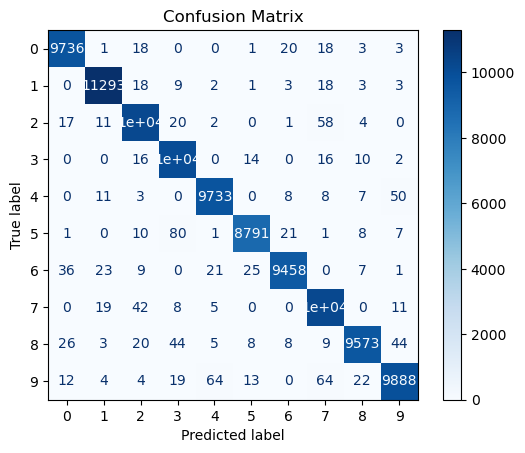

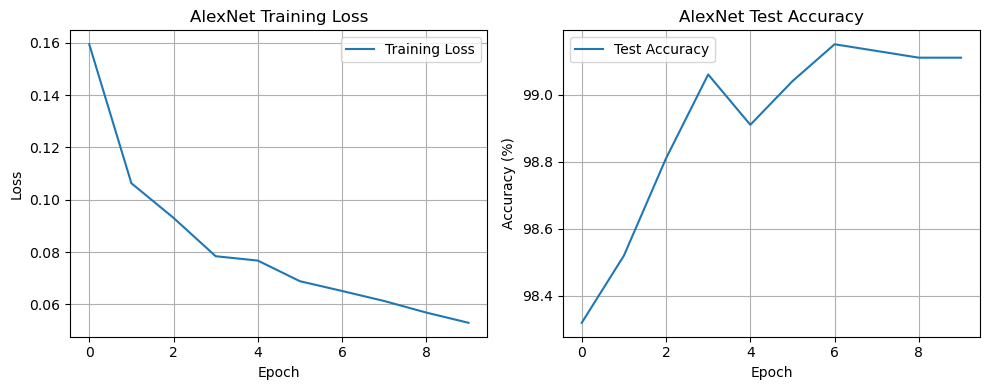


=== Running AlexNet for CIFAR10 ===
Files already downloaded and verified
Files already downloaded and verified


C:\Users\asus\anaconda3\envs\envCV\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\asus\anaconda3\envs\envCV\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[AlexNet-CIFAR10] Epoch 1: 100%|██████████| 782/782 [01:32<00:00,  8.46it/s]


[AlexNet] Epoch 1/10 | Loss: 1.0404 | Accuracy: 73.07%


[AlexNet-CIFAR10] Epoch 2: 100%|██████████| 782/782 [01:31<00:00,  8.53it/s]


[AlexNet] Epoch 2/10 | Loss: 0.8677 | Accuracy: 72.78%


[AlexNet-CIFAR10] Epoch 3: 100%|██████████| 782/782 [01:32<00:00,  8.42it/s]


[AlexNet] Epoch 3/10 | Loss: 0.8072 | Accuracy: 74.84%


[AlexNet-CIFAR10] Epoch 4: 100%|██████████| 782/782 [01:32<00:00,  8.41it/s]


[AlexNet] Epoch 4/10 | Loss: 0.7689 | Accuracy: 74.86%


[AlexNet-CIFAR10] Epoch 5: 100%|██████████| 782/782 [01:32<00:00,  8.47it/s]


[AlexNet] Epoch 5/10 | Loss: 0.7262 | Accuracy: 77.44%


[AlexNet-CIFAR10] Epoch 6: 100%|██████████| 782/782 [01:32<00:00,  8.48it/s]


[AlexNet] Epoch 6/10 | Loss: 0.6917 | Accuracy: 76.18%


[AlexNet-CIFAR10] Epoch 7: 100%|██████████| 782/782 [01:33<00:00,  8.39it/s]


[AlexNet] Epoch 7/10 | Loss: 0.6636 | Accuracy: 77.98%


[AlexNet-CIFAR10] Epoch 8: 100%|██████████| 782/782 [01:32<00:00,  8.45it/s]


[AlexNet] Epoch 8/10 | Loss: 0.6349 | Accuracy: 78.27%


[AlexNet-CIFAR10] Epoch 9: 100%|██████████| 782/782 [01:31<00:00,  8.56it/s]


[AlexNet] Epoch 9/10 | Loss: 0.6158 | Accuracy: 78.55%


[AlexNet-CIFAR10] Epoch 10: 100%|██████████| 782/782 [01:35<00:00,  8.23it/s]


[AlexNet] Epoch 10/10 | Loss: 0.5911 | Accuracy: 78.47%

 Total Training Time: 926.53 seconds
 Total Inference Time: 201.66 seconds


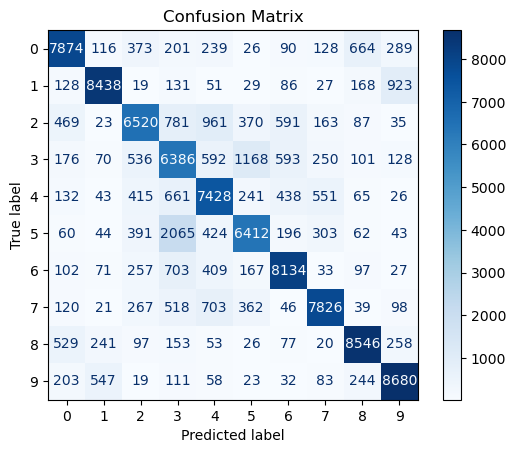

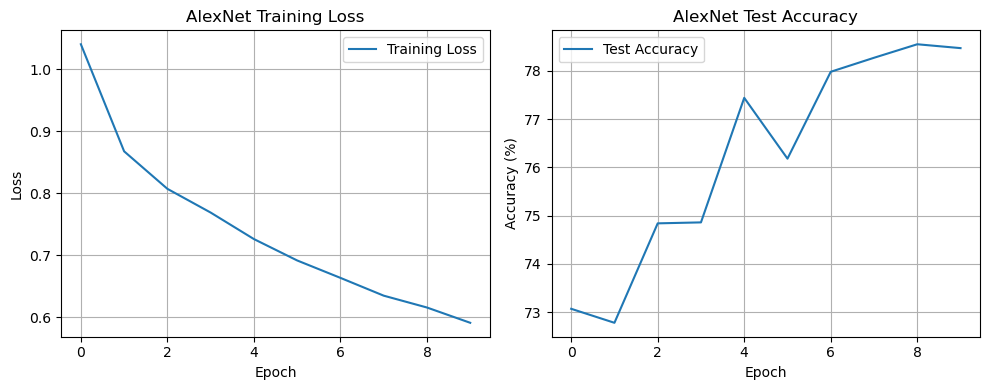

In [27]:
def train_alexnet_model(model, train_loader, test_loader, device, dataset_name):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, test_accuracies = [], []
    total_train_time = 0.0
    total_inference_time = 0.0
    all_preds, all_labels = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_start = time.time()

        for images, labels in tqdm(train_loader, desc=f"[AlexNet-{dataset_name}] Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        total_train_time += time.time() - epoch_start
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        correct, total = 0, 0
        inference_start = time.time()
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
        total_inference_time += time.time() - inference_start

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        print(f"[AlexNet] Epoch {epoch+1}/{num_epochs} | Loss: {train_losses[-1]:.4f} | Accuracy: {accuracy:.2f}%")

    print(f"\n Total Training Time: {total_train_time:.2f} seconds")
    print(f" Total Inference Time: {total_inference_time:.2f} seconds")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Visualization
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("AlexNet Training Loss")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("AlexNet Test Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    results['AlexNet'][dataset_name] = {
        'Accuracy (%)': test_accuracies[-1],
        'Train Time (s)': total_train_time,
        'Inference Time (s)': total_inference_time
    }

def run_alexnet_for_dataset(dataset_name): 
    print(f"\n=== Running AlexNet for {dataset_name} ===")
    
    use_rgb = True
    resize_to_224 = True 

    train_data, test_data, train_loader, test_loader, in_channels, _, class_names = load_dataset(
        dataset_name,
        batch_size,
        use_rgb=use_rgb,
        resize_to_224=resize_to_224
    )

    alexnet_model = get_alexnet_model(num_classes=len(class_names))
    train_alexnet_model(alexnet_model, train_loader, test_loader, device, dataset_name)

run_alexnet_for_dataset("MNIST")
run_alexnet_for_dataset("CIFAR10")

### 4.3 Training for Patch-based LSTM


=== Running LSTM for MNIST ===


[Patch-LSTM-MNIST] Epoch 1: 100%|██████████| 938/938 [00:09<00:00, 102.98it/s]


[LSTM] Epoch 1/10 | Loss: 1.1026 | Accuracy: 80.36%


[Patch-LSTM-MNIST] Epoch 2: 100%|██████████| 938/938 [00:09<00:00, 103.79it/s]


[LSTM] Epoch 2/10 | Loss: 0.4458 | Accuracy: 90.93%


[Patch-LSTM-MNIST] Epoch 3: 100%|██████████| 938/938 [00:08<00:00, 108.76it/s]


[LSTM] Epoch 3/10 | Loss: 0.2453 | Accuracy: 94.83%


[Patch-LSTM-MNIST] Epoch 4: 100%|██████████| 938/938 [00:08<00:00, 106.96it/s]


[LSTM] Epoch 4/10 | Loss: 0.1675 | Accuracy: 95.50%


[Patch-LSTM-MNIST] Epoch 5: 100%|██████████| 938/938 [00:09<00:00, 103.65it/s]


[LSTM] Epoch 5/10 | Loss: 0.1270 | Accuracy: 97.01%


[Patch-LSTM-MNIST] Epoch 6: 100%|██████████| 938/938 [00:09<00:00, 103.75it/s]


[LSTM] Epoch 6/10 | Loss: 0.1065 | Accuracy: 96.01%


[Patch-LSTM-MNIST] Epoch 7: 100%|██████████| 938/938 [00:09<00:00, 98.00it/s] 


[LSTM] Epoch 7/10 | Loss: 0.0908 | Accuracy: 97.37%


[Patch-LSTM-MNIST] Epoch 8: 100%|██████████| 938/938 [00:08<00:00, 105.23it/s]


[LSTM] Epoch 8/10 | Loss: 0.0787 | Accuracy: 96.81%


[Patch-LSTM-MNIST] Epoch 9: 100%|██████████| 938/938 [00:08<00:00, 111.16it/s]


[LSTM] Epoch 9/10 | Loss: 0.0697 | Accuracy: 97.89%


[Patch-LSTM-MNIST] Epoch 10: 100%|██████████| 938/938 [00:08<00:00, 109.47it/s]


[LSTM] Epoch 10/10 | Loss: 0.0635 | Accuracy: 98.21%

 Total Training Time: 89.20 seconds
 Total Inference Time: 38.79 seconds


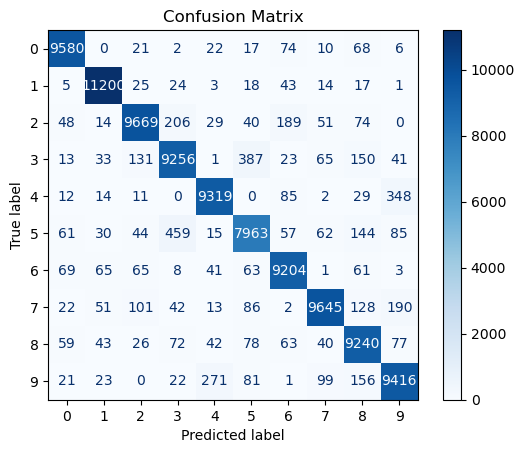

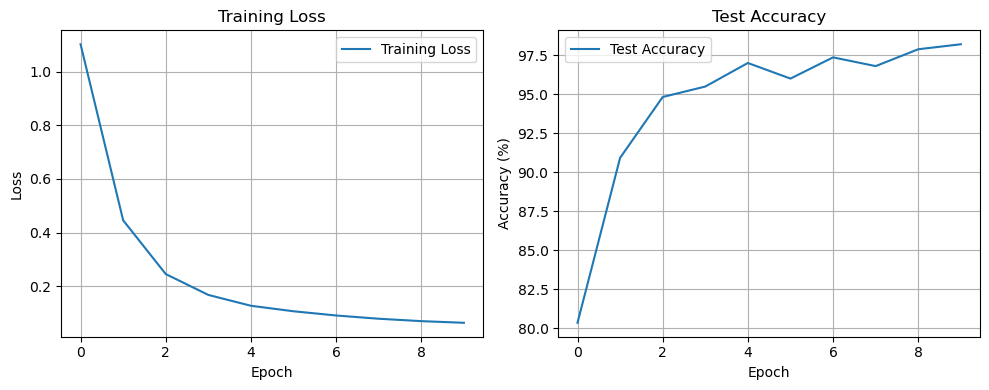


=== Running LSTM for CIFAR10 ===
Files already downloaded and verified
Files already downloaded and verified


[Patch-LSTM-CIFAR10] Epoch 1: 100%|██████████| 782/782 [00:20<00:00, 38.51it/s]


[LSTM] Epoch 1/10 | Loss: 1.8970 | Accuracy: 35.43%


[Patch-LSTM-CIFAR10] Epoch 2: 100%|██████████| 782/782 [00:20<00:00, 37.61it/s]


[LSTM] Epoch 2/10 | Loss: 1.6909 | Accuracy: 40.65%


[Patch-LSTM-CIFAR10] Epoch 3: 100%|██████████| 782/782 [00:20<00:00, 37.66it/s]


[LSTM] Epoch 3/10 | Loss: 1.5700 | Accuracy: 44.08%


[Patch-LSTM-CIFAR10] Epoch 4: 100%|██████████| 782/782 [00:19<00:00, 39.20it/s]


[LSTM] Epoch 4/10 | Loss: 1.4745 | Accuracy: 47.01%


[Patch-LSTM-CIFAR10] Epoch 5: 100%|██████████| 782/782 [00:20<00:00, 38.13it/s]


[LSTM] Epoch 5/10 | Loss: 1.3924 | Accuracy: 50.34%


[Patch-LSTM-CIFAR10] Epoch 6: 100%|██████████| 782/782 [00:19<00:00, 39.11it/s]


[LSTM] Epoch 6/10 | Loss: 1.3274 | Accuracy: 51.23%


[Patch-LSTM-CIFAR10] Epoch 7: 100%|██████████| 782/782 [00:19<00:00, 40.83it/s]


[LSTM] Epoch 7/10 | Loss: 1.2716 | Accuracy: 52.34%


[Patch-LSTM-CIFAR10] Epoch 8: 100%|██████████| 782/782 [00:19<00:00, 39.49it/s]


[LSTM] Epoch 8/10 | Loss: 1.2203 | Accuracy: 52.74%


[Patch-LSTM-CIFAR10] Epoch 9: 100%|██████████| 782/782 [00:19<00:00, 40.04it/s]


[LSTM] Epoch 9/10 | Loss: 1.1758 | Accuracy: 54.41%


[Patch-LSTM-CIFAR10] Epoch 10: 100%|██████████| 782/782 [00:18<00:00, 41.62it/s]


[LSTM] Epoch 10/10 | Loss: 1.1358 | Accuracy: 55.36%

 Total Training Time: 199.66 seconds
 Total Inference Time: 81.44 seconds


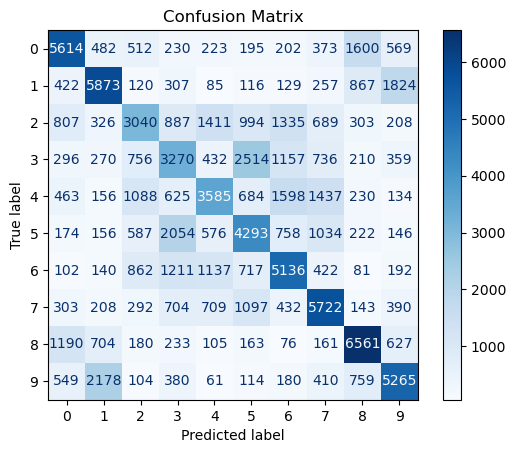

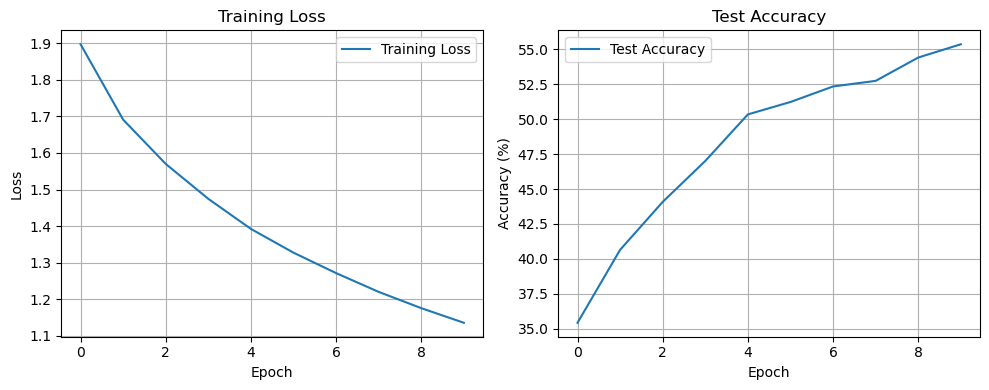

In [28]:
def train_lstm_model(model, train_loader, test_loader, device, dataset_name):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, test_accuracies = [], []
    total_train_time = 0.0
    total_inference_time = 0.0
    all_preds, all_labels = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_start = time.time()

        for images, labels in tqdm(train_loader, desc=f"[Patch-LSTM-{dataset_name}] Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        total_train_time += time.time() - epoch_start
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        correct, total = 0, 0
        inference_start = time.time()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        total_inference_time += time.time() - inference_start

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        print(f"[LSTM] Epoch {epoch+1}/{num_epochs} | Loss: {train_losses[-1]:.4f} | Accuracy: {accuracy:.2f}%")

    print(f"\n Total Training Time: {total_train_time:.2f} seconds")
    print(f" Total Inference Time: {total_inference_time:.2f} seconds")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    
    results['Patch-LSTM'][dataset_name] = {
        'Accuracy (%)': test_accuracies[-1],
        'Train Time (s)': total_train_time,
        'Inference Time (s)': total_inference_time
    }

    # Plot
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Test Accuracy")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

def run_lstm_for_dataset(dataset_name): 
    print(f"\n=== Running LSTM for {dataset_name} ===")

    train_data, test_data, train_loader, test_loader, in_channels, image_size, class_names = load_dataset(
        dataset_name,
        batch_size=batch_size,
        use_rgb=False
    )

    lstm_model = PatchLSTM(
        image_size=image_size,
        patch_size=patch_size,
        in_channels=in_channels,
        hidden_size=hidden_size,
        num_classes=len(class_names)
    )

    train_lstm_model(lstm_model, train_loader, test_loader, device, dataset_name)

run_lstm_for_dataset("MNIST")
run_lstm_for_dataset("CIFAR10")

## 5. Comparative Results and Discussion

In [29]:
summary_df = pd.DataFrame.from_dict(
    {(model, ds): metrics for model, datasets in results.items() for ds, metrics in datasets.items()}, orient='index'
).reset_index()

summary_df.columns = ['Model', 'Dataset', 'Accuracy (%)', 'Train Time (s)', 'Inference Time (s)']
summary_df

,Model,Dataset,Accuracy (%),Train Time (s),Inference Time (s)
0,CNN,MNIST,99.07,94.582533,39.737669
1,CNN,CIFAR10,70.89,202.711349,85.106063
2,AlexNet,MNIST,99.11,1031.892517,139.292977
3,AlexNet,CIFAR10,78.47,926.530733,201.659584
4,Patch-LSTM,MNIST,98.21,89.203956,38.785510
5,Patch-LSTM,CIFAR10,55.36,199.662931,81.438858


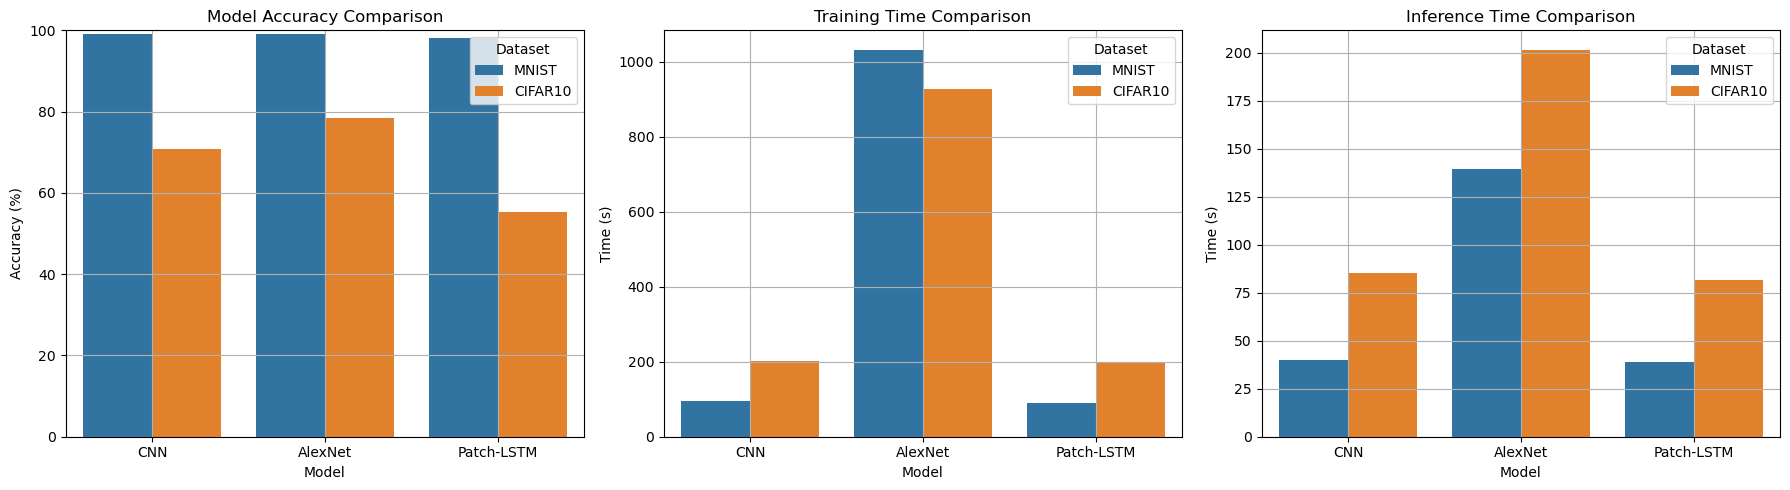

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
sns.barplot(data=summary_df, x='Model', y='Accuracy (%)', hue='Dataset', ax=axes[0])
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_xlabel('Model')
axes[0].grid(True)
axes[0].set_ylim(0, 100)

# Training Time
sns.barplot(data=summary_df, x='Model', y='Train Time (s)', hue='Dataset', ax=axes[1])
axes[1].set_title('Training Time Comparison')
axes[1].set_ylabel('Time (s)')
axes[1].set_xlabel('Model')
axes[1].grid(True)

# Inference Time
sns.barplot(data=summary_df, x='Model', y='Inference Time (s)', hue='Dataset', ax=axes[2])
axes[2].set_title('Inference Time Comparison')
axes[2].set_ylabel('Time (s)')
axes[2].set_xlabel('Model')
axes[2].grid(True)

plt.tight_layout()
plt.show()